In [1]:
import matplotlib.pyplot as plt
import itertools
import hoomd
import math

import xarray as xr
import numpy
import gsd.hoomd
import sphere_fres as sf
import model_tools as mt


In [2]:
# build simulation
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=0)
sim.create_state_from_gsd(filename='random.gsd')

#simulation parameters
initial_kT = 0.28

In [3]:
sx,sz,sy,sa,sb,sc,data_map = mt.get_data("mt_full_new.nc")

patch_param_array = numpy.append(data_map,initial_kT)

In [4]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0.8)
mc.shape['A'] = dict(diameter=1, orientable=True)
sim.operations.integrator = mc


In [5]:
patch_code = mt.patch_code(sx,sz,sy,sa,sb,sc)


In [6]:
patch_potential = hoomd.hpmc.pair.user.CPPPotential(r_cut=10,
                                                    code=patch_code,
                                                    param_array=patch_param_array)

mc.pair_potential = patch_potential
sim.run(0000)
print(patch_potential.energy)

91353579520.0


In [7]:
logger = hoomd.logging.Logger()
logger.add(patch_potential, quantities=[
    'energy',
])
logger[('kT',)] = (lambda: patch_potential.param_array[sx*sz*sy*sa*sb*sc], 'scalar')
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(500),
                             mode='wb',
                             filter=hoomd.filter.Null(),
                             logger=logger)
sim.operations.writers.append(gsd_writer)


In [8]:
sim.run(50000)
#patch_potential.param_array[74088] = 0.26
#sim.run(20000)
#patch_potential.param_array[74088] = 0.28
#sim.run(20000)


In [9]:
gsd_writer.flush()

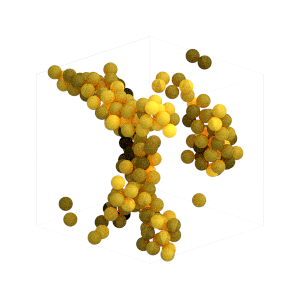

In [10]:
sf.render(sim.state.get_snapshot(),120*1.4)

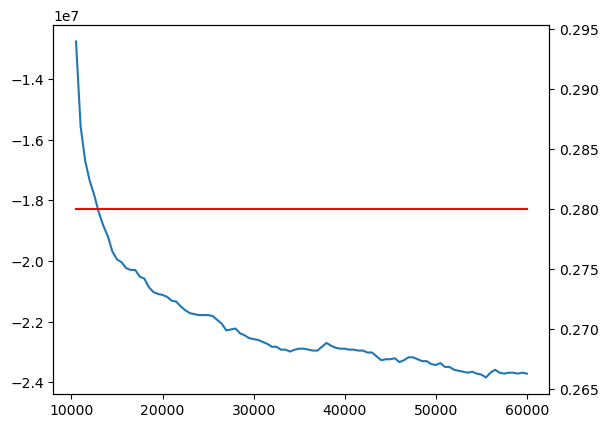

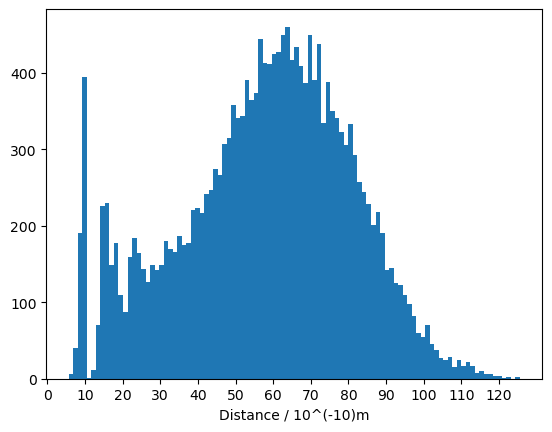

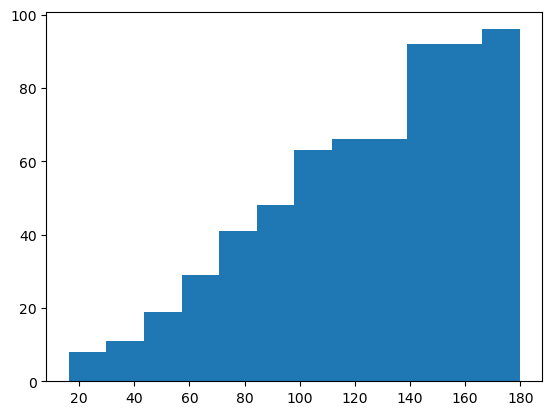

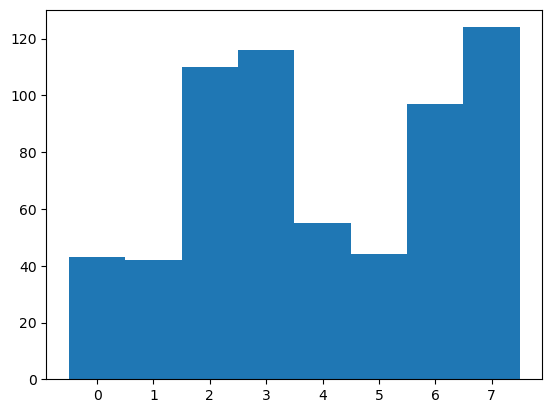

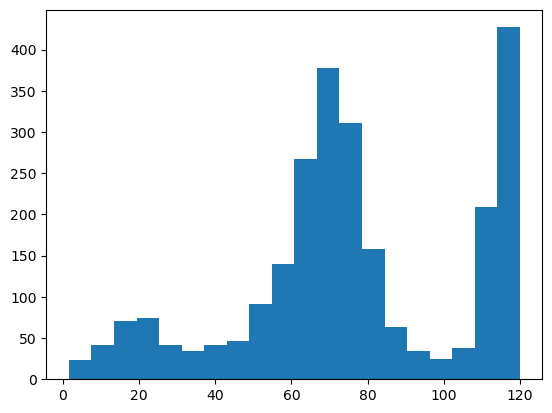

In [11]:
mt.graphs(sim)